# INDENG 242A Fall 2024 Final Project
#### Team Members: Veer Arora, Vincent Karpf, Paige Lyles, Luis Schmitz

In [ ]:
#Data Selection and Metrics definitions done by Veer Arora in conjunction with group members
#Models in this file built by Veer Arora: Classification Tree and Random Fores + Interpretations and Visualizations

import os
import numpy as np
import pandas as pd
import sklearn
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import resample
from sklearn.metrics import precision_score, make_scorer, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
import shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Data

In [ ]:
directory_luis='/content/drive/MyDrive/Berkeley/Machine Learning 1/Startup Success Machine Learning Folder/Pitchbook/AB2_Data_FeatureENG_page_1_253+X.csv'
directory_veer = '/content/drive/MyDrive/Startup Success Machine Learning Folder/Pitchbook/AB2_Data_FeatureENG_page_1_253+X.csv'
directory_vincent = '/content/drive/MyDrive/Startup Success Machine Learning Folder/Pitchbook/AB2_Data_FeatureENG_page_1_253+X.csv'
directory_paige = '/content/drive/MyDrive/Copy of AB2_Data_FeatureENG_page_1_253+X.csv'
data=pd.read_csv(directory_veer)

## Step 1: Data Selection (Includes Train, Test Split)

Selecting Section of Data: We are only looking at the first VC Round for predicting Success

In [ ]:
print('data shape before filtering:',data.shape)
data= data[data['is_first_round']==1]
data = data[
    data['Deal Type (Series)'].isin(['Angel (individual)', 'Seed Round', 'Series A']) |
    data['Deal Type (Series)'].isna()
]
print('data shape after filtering:',data.shape)

data shape before filtering: (29577, 874)
data shape after filtering: (10525, 874)


 Drop of columns that are uneccessary and data that has NaN

In [ ]:
data= data.drop(columns=['Company ID', 'is_first_round','is_last_round','VC Round','Deal Type (Series)'])
data=data.dropna()

Defining the Target Variable

In [ ]:
# Potential Variables to select for the target variable:

Target_Unicorn='Unicorn'
Target_Valuation_100m='Valuation > 100m'
Target_Raised_100m='Raised > 100m'

# Select Target
y_data=data[Target_Valuation_100m]

Select Baseline Independent Features by dropping target variable and
Dropping Helper Variables

In [ ]:
X_data= data.drop(columns=[Target_Unicorn,Target_Valuation_100m,Target_Raised_100m])

Split in Train Test

In [ ]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

Dropping irrelevant features as noted in our feature google sheet

In [ ]:
x_train_reduced = X_train
x_test_reduced = X_test

# Machine Learning Models

## Define Metrics and Output

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

def evaluate_classification(y_test, predictions):
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

    # Calculate metrics
    acc_baseline = accuracy_score(y_test, predictions)
    tpr_baseline = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr_baseline = fp / (fp + tn) if (fp + tn) != 0 else 0
    precision_baseline = tp / (tp + fp) if (tp + fp) != 0 else 0

    # Return the values in the required order
    return acc_baseline, tpr_baseline, fpr_baseline, precision_baseline, tp, fp
    return metrics

# Baseline Model

In [ ]:
# we have a list of startups which all got VC or angel funding there fore baseline is investing or believing they will be sucessful
baseline_pred = np.ones(len(y_test))

acc_baseline,tpr_baseline,fpr_baseline,precision_baseline,tp_baseline,fp_baseline =evaluate_classification(y_test,baseline_pred)

print("Test Set Classification Report:")
print('Accuracy:',acc_baseline)
print('TPR:',tpr_baseline)
print('FPR:',fpr_baseline)
print('Precision:',precision_baseline)
print('#True Positives:',tp_baseline)
print('#False Positives:',fp_baseline)

Test Set Classification Report:
Accuracy: 0.08895184135977337
TPR: 1.0
FPR: 1.0
Precision: 0.08895184135977337
#True Positives: 157
#False Positives: 1608


## Logistic Regression

#### Model training and cross validation

In [ ]:
def logreg_modeling(X, y):

    # Define preprocessing pipeline
    pipeline = Pipeline([
        # Standardize data
        ('scaler', StandardScaler()),
        # Feature selection using Elastic Net
        ('feature_selection', SelectFromModel(
            ElasticNetCV(cv=5, max_iter=10000, verbose=1), threshold='mean')),
        # Define Logistic Regression classifier with Elastic Net Penalty
        ('classifier', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000, class_weight='balanced'))])

    # Stratified KFold Cross-Validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Hyperparameter Tuning
    def hyperparameter_tuning():

        param_grid = {
            'feature_selection__estimator__alphas': [[0.01, 0.1, 1]],
            'feature_selection__estimator__l1_ratio': [0.5, 0.7, 0.9],
            'feature_selection__max_features': [120, 150, 200, 250],
            'classifier__C': [0.01, 0.02, 0.03],
            'classifier__l1_ratio': [0.85, 0.9, 0.95, 1],
            'classifier__class_weight': ['balanced', {0:1, 1:5}]}

        # Perform grid search over parameters for feature selection and model regularization
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=2)
        grid_search.fit(X, y)

        return {'best_params': grid_search.best_params_, 'best_score': grid_search.best_score_}

    # Get best parameters
    best_params = hyperparameter_tuning()

    return best_params

In [ ]:
results = logreg_modeling(x_train_reduced, y_train)
results

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


.............../usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'best_params': {'classifier__C': 0.03,
  'classifier__class_weight': {0: 1, 1: 5},
  'classifier__l1_ratio': 0.85,
  'feature_selection__estimator__alphas': [0.01, 0.1, 1],
  'feature_selection__estimator__l1_ratio': 0.5,
  'feature_selection__max_features': 120},
 'best_score': 0.34304282587022983}

#### Fit best model

In [ ]:
# Define pipeline with best parameters
best_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectFromModel(
            ElasticNetCV(l1_ratio=0.5,
                         alphas=[0.01, 0.1, 1], cv=5, max_iter=10000),
            threshold='mean', max_features=120)),
        ('classifier', LogisticRegression(
            penalty='elasticnet', solver='saga', l1_ratio=0.85,
            C=0.03, max_iter=10000, class_weight={0: 1, 1: 5}))])

# Fit best pipeline
best_pipeline.fit(x_train_reduced, y_train)
y_pred_proba = best_pipeline.predict_proba(x_test_reduced)
y_pred_proba = pd.Series([y[1] for y in y_pred_proba])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Evaluate model using threshold

In [ ]:
# Set probability threshold
p = 0.5

y_log_pred = [1 if y > p else 0 for y in y_pred_proba]

# Evaluate regularized Logistic Regression model
acc_log,tpr_log,fpr_log,precision_log,tp_log,fp_log =evaluate_classification(y_test,y_log_pred)

print("Test Set Classification Report:")
print('Accuracy:',acc_log)
print('TPR:',tpr_log)
print('FPR:',fpr_log)
print('Precision:',precision_log)
print('#True Positives:',tp_log)
print('#False Positives:',fp_log)

Test Set Classification Report:
Accuracy: 0.8611898016997167
TPR: 0.4968152866242038
FPR: 0.10323383084577115
Precision: 0.319672131147541
#True Positives: 78
#False Positives: 166


#### Probability distribution



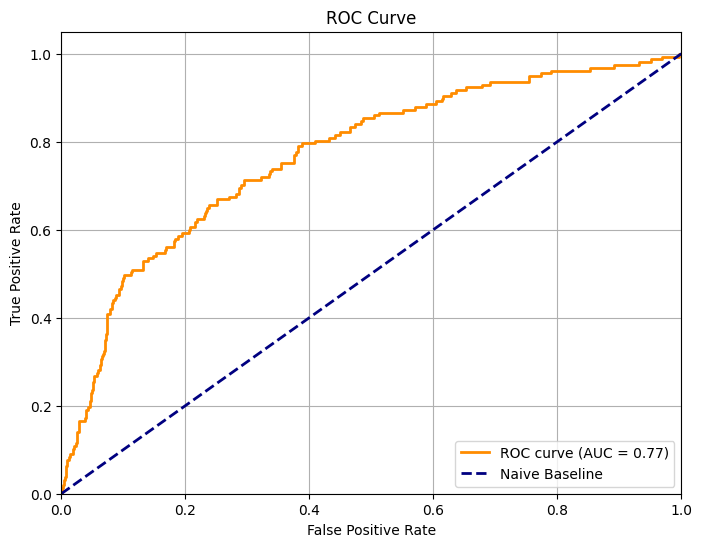

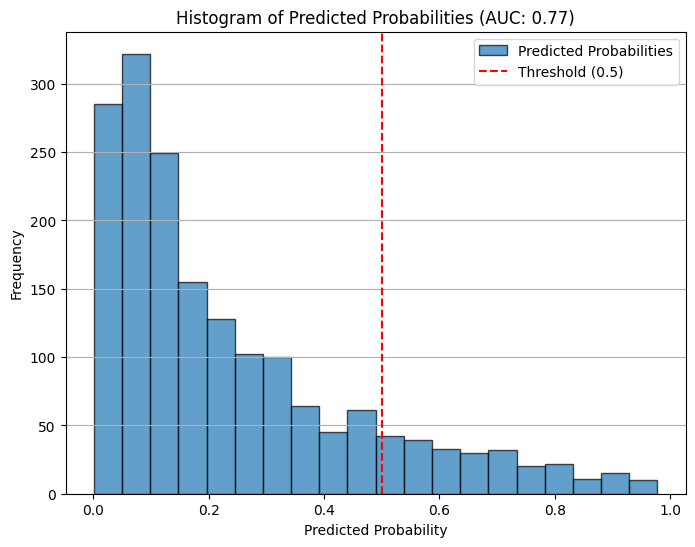

In [ ]:
auc_log = roc_auc_score(y_test, y_pred_proba)
fpr_log2, tpr_log2, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr_log2, tpr_log2)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_log2, tpr_log2, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Naive Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)

plt.show()

# Plot predicted probabilities and trheshold
plt.figure(figsize=(8, 6))
plt.hist(y_pred_proba, bins=20, alpha=0.7, edgecolor='black', label='Predicted Probabilities')
plt.axvline(x=p, color='red', linestyle='--', label='Threshold (0.5)')
plt.title(f'Histogram of Predicted Probabilities (AUC: {auc_log:.2f})')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y')
plt.show()

#### Coefficient Analysis

In [ ]:
def get_feature_coefficients(pipeline, feature_names):

    # Get selected features
    selector_mask = pipeline.named_steps['feature_selection'].get_support()
    selected_features = np.array(feature_names)[selector_mask]

    # Get logistic regression coefficients
    coefficients = pipeline.named_steps['classifier'].coef_[0]

    result_df = pd.DataFrame({
        'Feature': selected_features,
        'Coefficient': coefficients
    }).sort_values('Coefficient', key=abs, ascending=False)

    return result_df

# Plot the top 30 model coefficients
def plot_feature_coefficients(results_df, top_n=30):
    plt.figure(figsize=(10, 8))
    top_features = results_df.head(top_n)

    plt.bar(top_features['Feature'], top_features['Coefficient'])
    plt.title(f'Top {top_n} Feature Coefficients')
    plt.xlabel('Features')
    plt.ylabel('Coefficient')
    plt.xticks(rotation=90)
    plt.tight_layout()

    return plt

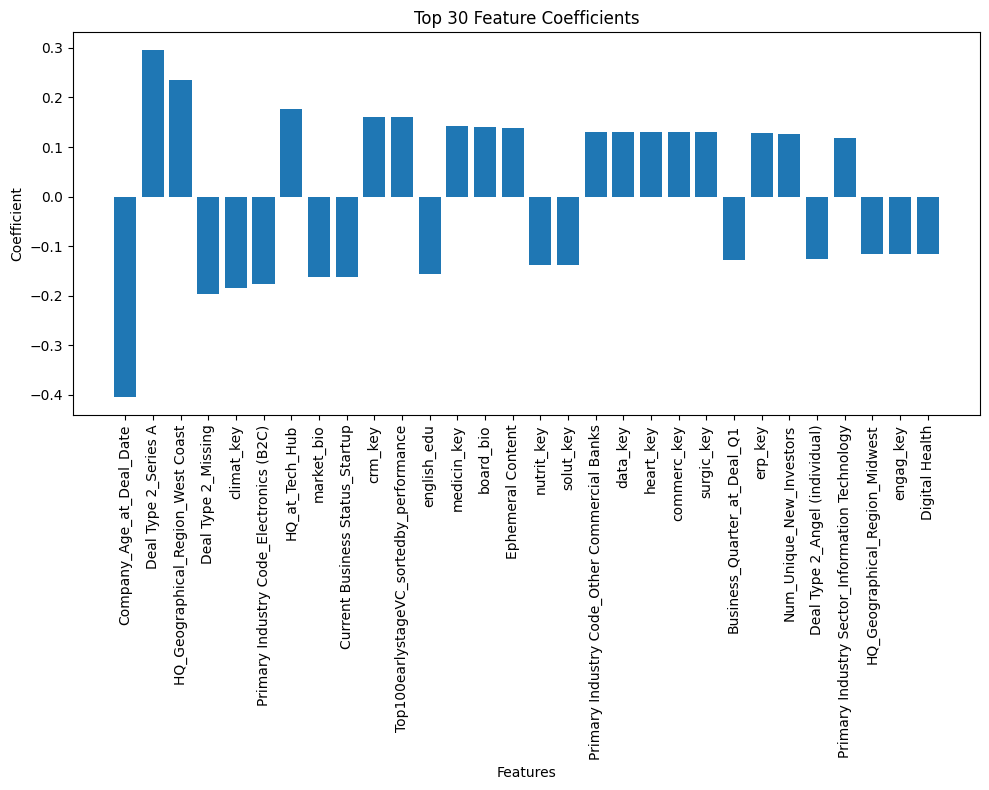

In [ ]:
coef_df = get_feature_coefficients(best_pipeline, x_train_reduced.columns.values)
plot = plot_feature_coefficients(coef_df)
plot.show()

In [ ]:
coef_df.head(30)

,Feature,Coefficient
3,Company_Age_at_Deal_Date,-0.405297
34,Deal Type 2_Series A,0.296335
37,HQ_Geographical_Region_West Coast,0.234949
33,Deal Type 2_Missing,-0.197184
59,climat_key,-0.183682
19,Primary Industry Code_Electronics (B2C),-0.177157
4,HQ_at_Tech_Hub,0.176326
108,market_bio,-0.162378
29,Current Business Status_Startup,-0.161494
63,crm_key,0.160630


## Classification Tree

In [ ]:
param_grid = {'ccp_alpha': [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1],
              'min_samples_leaf': [2, 3, 5, 8, 12],
              'random_state': [1]
              }

# Cross-validation
model_CART = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='f1')

# Predicting using best ccp_alpha from cross-validation
model_CART.fit(x_train_reduced, y_train)
y_CART_pred= model_CART.predict(x_test_reduced)

#Get the best parameter
best_params = model_CART.best_params_
print ('The best Parameter is:',best_params)

# Evaluation
acc_CART,tpr_CART,fpr_CART,precision_CART,tp_CART,fp_CART =evaluate_classification(y_test,y_CART_pred)

print("Test Set Classification Report:")
print('Accuracy:',acc_CART)
print('TPR:',tpr_CART)
print('FPR:',fpr_CART)
print('Precision:',precision_CART)
print('#True Positives:',tp_CART)
print('#False Positives:',fp_CART)

The best Parameter is: {'ccp_alpha': 0.0001, 'min_samples_leaf': 2, 'random_state': 1}
Test Set Classification Report:
Accuracy: 0.8776203966005666
TPR: 0.19745222929936307
FPR: 0.055970149253731345
Precision: 0.256198347107438
#True Positives: 31
#False Positives: 90


### Providing Interpretation of attributes for the CART model

#### Feature Importance

In [ ]:
model_CART_best=model_CART.best_estimator_
# Getting feature importance
feature_importances_CART = pd.DataFrame({
    'Feature': x_train_reduced.columns,
    'Importance': model_CART_best.feature_importances_
}).sort_values(by='Importance', ascending=False)
feature_importances_CART.head(20)


,Feature,Importance
3,Num_Unique_New_Investors,0.036775
4,Company_Age_at_Deal_Date,0.036724
294,Deal Type 2_Series A,0.023604
498,data_key,0.022108
492,crm_key,0.019008
737,chief_bio,0.018798
805,member_bio,0.018299
618,plan_key,0.016845
585,manag_key,0.015779
726,board_bio,0.015409


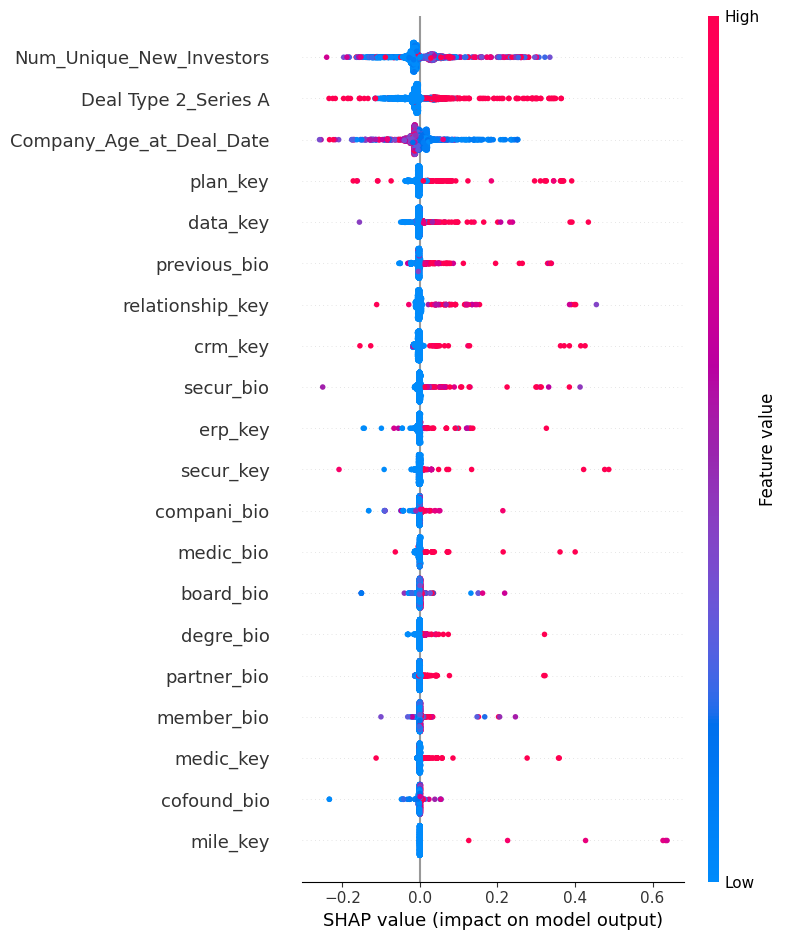

In [ ]:
# Analyze shap values for feature importance
explain_CART = shap.TreeExplainer(model_CART_best)
shap_values = explain_CART.shap_values(x_test_reduced)
shap_values_class1 = shap_values[..., 1]

# Plot shap values
shap.summary_plot(shap_values_class1, x_test_reduced)
shap.force_plot(
    explainer_CART.expected_value[1],
    shap_values_class1[0, :],
    x_test_reduced.iloc[0, :]
)

## Random Forest

In [ ]:
# Define parameter grid
param_grid = {
    'n_estimators': [600, 700, 800, 900],
    'max_features': [4, 5, 6, 7, 8],
    #'max_depth': [200, 300, None],
    #'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [10, 12, 14, 16],
    'class_weight': ['balanced', None],
    #'max_leaf_nodes': [None, 50, 100, 200],
    'random_state': [1]
}


# Cross-validation
model_RF = GridSearchCV(
    RandomForestClassifier(),
    param_grid,
    cv= StratifiedKFold(n_splits=5),
    scoring='f1',
    verbose=2)
model_RF.fit(x_train_reduced, y_train)
y_RF_pred= model_RF.predict(x_test_reduced)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] END class_weight=balanced, max_depth=200, max_features=5, min_samples_leaf=8, n_estimators=600, random_state=1; total time=   3.9s
[CV] END class_weight=balanced, max_depth=200, max_features=5, min_samples_leaf=8, n_estimators=600, random_state=1; total time=   4.7s
[CV] END class_weight=balanced, max_depth=200, max_features=5, min_samples_leaf=8, n_estimators=600, random_state=1; total time=   4.9s
[CV] END class_weight=balanced, max_depth=200, max_features=5, min_samples_leaf=8, n_estimators=600, random_state=1; total time=   3.9s
[CV] END class_weight=balanced, max_depth=200, max_features=5, min_samples_leaf=8, n_estimators=600, random_state=1; total time=   3.8s
[CV] END class_weight=balanced, max_depth=200, max_features=5, min_samples_leaf=8, n_estimators=700, random_state=1; total time=   6.0s
[CV] END class_weight=balanced, max_depth=200, max_features=5, min_samples_leaf=8, n_estimators=700, random_state=1; tot

#### Evaluation

In [ ]:
#Get the best parameter
best_params = model_RF.best_params_
print ('The best Parameter is:',best_params)

# Evaluation
acc_RF,tpr_RF,fpr_RF,precision_RF,tp_RF,fp_RF =evaluate_classification(y_test,y_RF_pred)

print("Test Set Classification Report:")
print('Accuracy:',acc_RF)
print('TPR:',tpr_RF)
print('FPR:',fpr_RF)
print('Precision:',precision_RF)
print('#True Positives:',tp_RF)
print('#False Positives:',fp_RF)

The best Parameter is: {'class_weight': 'balanced', 'max_features': 7, 'min_samples_leaf': 10, 'n_estimators': 700, 'random_state': 1}
Test Set Classification Report:
Accuracy: 0.888385269121813
TPR: 0.4012738853503185
FPR: 0.0640547263681592
Precision: 0.3795180722891566
#True Positives: 63
#False Positives: 103


#### Feature Importance

In [ ]:
# Get RF feature importance scores
best_model_rf = model_RF.best_estimator_
feature_importances = best_model_rf.feature_importances_

feature_importance_df_RF = pd.DataFrame({
    'Feature': x_train_reduced.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(feature_importance_df_RF)

                                               Feature  Importance
3                             Num_Unique_New_Investors    0.027857
294                               Deal Type 2_Series A    0.023519
4                             Company_Age_at_Deal_Date    0.022950
315                  HQ_Geographical_Region_West Coast    0.017630
585                                          manag_key    0.013220
..                                                 ...         ...
106  Primary Industry Code_Discovery Tools (Healthc...    0.000000
214  Primary Industry Code_Paper Containers and Pac...    0.000000
213  Primary Industry Code_Outcome Management (Heal...    0.000000
80        Primary Industry Code_BPO/Outsource Services    0.000000
123               Primary Industry Code_Energy Storage    0.000000

[866 rows x 2 columns]


####Shap Values

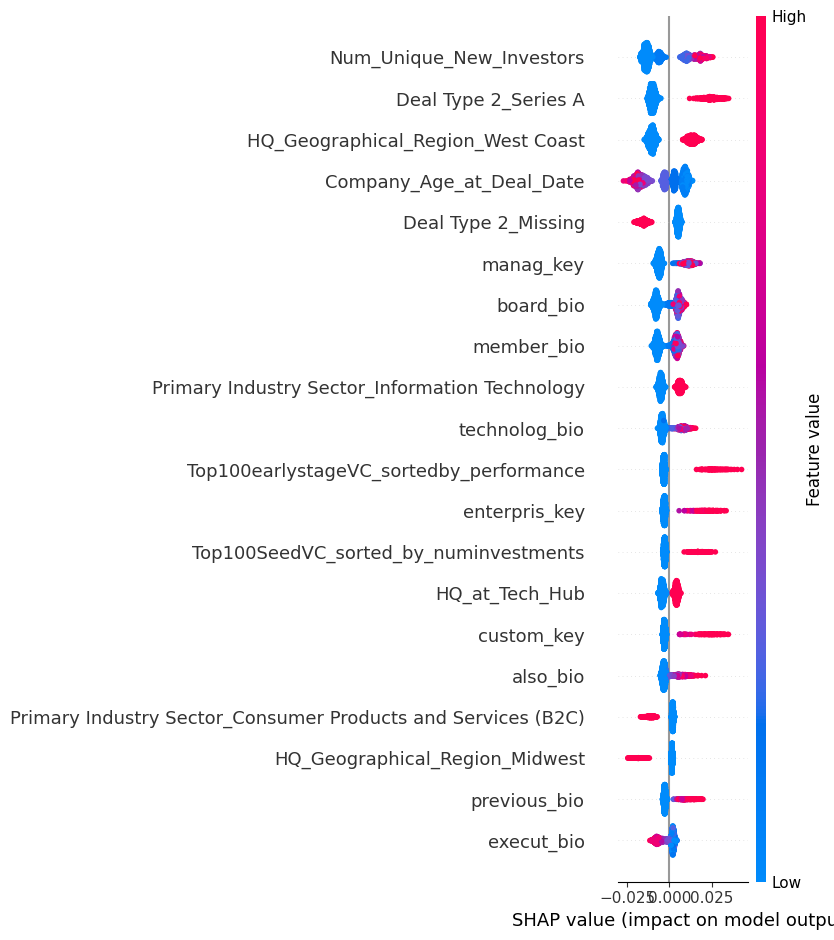

In [ ]:
# Analyze shap values for feature importance
explain_RF = shap.TreeExplainer(best_model_rf)
shap_values = explain_RF.shap_values(x_test_reduced)
shap_values_class1 = shap_values[..., 1]

# Plot shap values
shap.summary_plot(shap_values_class1, x_test_reduced)
shap.force_plot(
    explainer_RF.expected_value[1],
    shap_values_class1[0, :],
    x_test_reduced.iloc[0, :]
)

## Gradient Boosting

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

param_grid = {
    'n_estimators': [500, 800],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [10, 13, 16],
    'max_features': [3, 5, 7],
    'random_state': [1]
}

# Cross-validation
model_GB = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, scoring='f1', verbose = 2)
model_GB.fit(x_train_reduced, y_train)

#Get the best parameter
best_params = model_GB.best_params_
print ('The best Parameter is:',best_params)

#Make prediction
y_GB_pred= model_GB.predict(x_test_reduced)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END learning_rate=0.01, max_depth=3, max_features=3, min_samples_leaf=10, n_estimators=500, random_state=1; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=3, max_features=3, min_samples_leaf=10, n_estimators=500, random_state=1; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=3, max_features=3, min_samples_leaf=10, n_estimators=500, random_state=1; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=3, max_features=3, min_samples_leaf=10, n_estimators=500, random_state=1; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=3, min_samples_leaf=10, n_estimators=500, random_state=1; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=3, max_features=3, min_samples_leaf=10, n_estimators=800, random_state=1; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=3, max_features=3, min_samples_leaf=10, n_estimators=800, random_state=1; total time=   1.9s
[CV] END lear

#### Evaluation

In [ ]:
# Evaluation
acc_GB,tpr_GB,fpr_GB,precision_GB,tp_GB,fp_GB =evaluate_classification(y_test,y_GB_pred)

print("Test Set Classification Report:")
print('Accuracy:',acc_GB)
print('TPR:',tpr_GB)
print('FPR:',fpr_GB)
print('Precision:',precision_GB)
print('#True Positives:',tp_GB)
print('#False Positives:',fp_GB)

Test Set Classification Report:
Accuracy: 0.913314447592068
TPR: 0.12738853503184713
FPR: 0.009950248756218905
Precision: 0.5555555555555556
#True Positives: 20
#False Positives: 16


#### Feature Importance of the gradient boost

In [ ]:
# Get GB feature importance
best_model_GB = model_GB.best_estimator_
feature_importances = best_model_GB.feature_importances_

feature_importance_df_RF = pd.DataFrame({
    'Feature': x_train_reduced.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(feature_importance_df_RF)

                                               Feature  Importance
294                               Deal Type 2_Series A    0.027782
3                             Num_Unique_New_Investors    0.025571
4                             Company_Age_at_Deal_Date    0.025546
644                                   relationship_key    0.016523
315                  HQ_Geographical_Region_West Coast    0.014051
..                                                 ...         ...
199    Primary Industry Code_Other Healthcare Services    0.000000
203                  Primary Industry Code_Other Media    0.000000
38                                      Pet Technology    0.000000
204  Primary Industry Code_Other Metals, Minerals a...    0.000000
53                                    Impact Investing    0.000000

[866 rows x 2 columns]


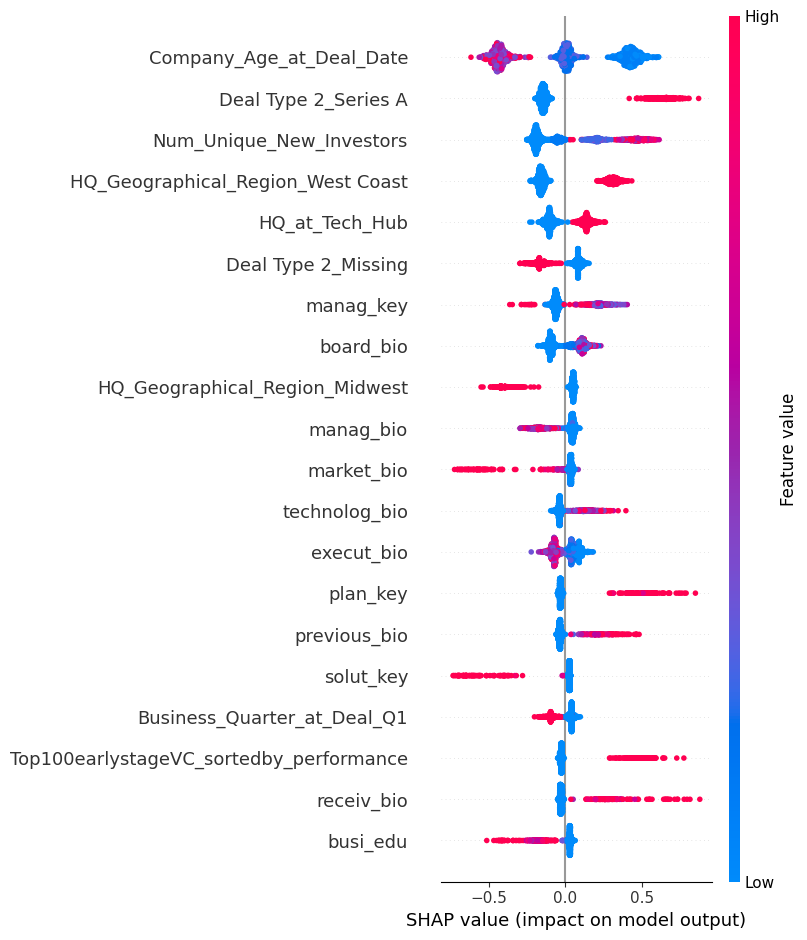

In [ ]:
# Analyze shap values for feature importance
explain_GB = shap.TreeExplainer(best_model_GB)
shap_values = explain_GB.shap_values(x_test_reduced)

# Plot shap values
shap.summary_plot(shap_values, x_test_reduced)
shap.force_plot(
    explainer_GB.expected_value,
    shap_values[0, :],
    x_test_reduced.iloc[0, :]
)